#### How do you become a professional developer in Germany?

As you might have interested in the people who were used to be a professional developer and worked in Germany. Here is the dataset of 2017 which had been download from Stackoverflow, let us see what kind of insights can we get from it. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import model_func as t
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./survey_results_public.csv')
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Question 1

**1.** Provide a pandas series of the counts for each FormalEducation status who were professional developer in Germany, then plot in a bar chart.

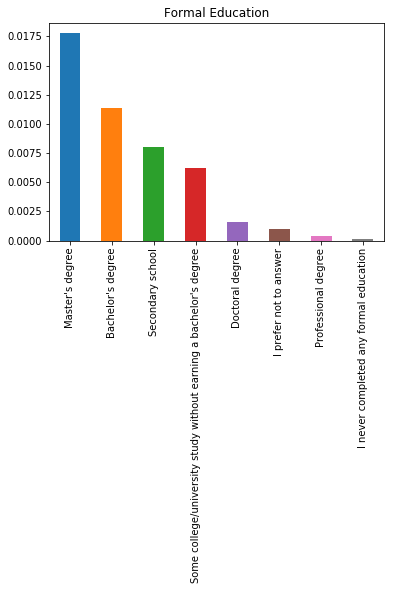

In [2]:
ed_vals = df[(df['Country']=='Germany')& (df['Professional']=='Professional developer')]['FormalEducation'].value_counts()#Provide a pandas series of the counts for each FormalEducation status
(ed_vals/df.shape[0]).plot(kind="bar");
plt.title("Formal Education");

#### Question 2

**2.** Now, we need to compare salary by gender  . Use the seaborn barplot below to provide the plot that shows separated FormalEducation by Gender. 

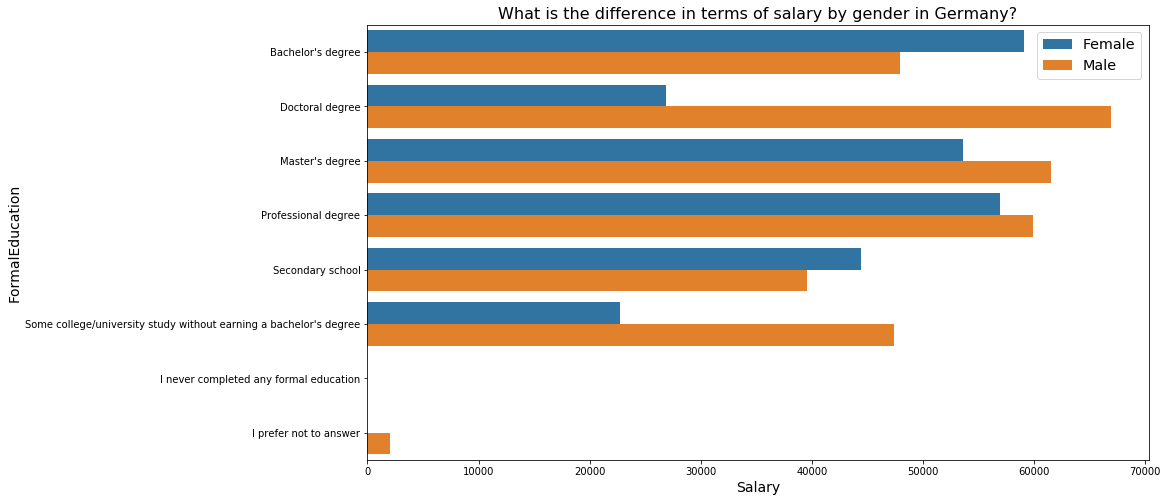

In [3]:
ef=pd.DataFrame(df.query("Professional == 'Professional developer' and Country=='Germany' and (Gender == 'Male' or Gender == 'Female')").groupby(['Gender', 'FormalEducation']).mean()['Salary'])
ef.reset_index(inplace=True)
# ef.columns
plt.figure(figsize=(14,8))

sns.barplot(x = 'Salary', 
            y = 'FormalEducation',
            hue = 'Gender',
            data = ef)
plt.xlabel("Salary", fontsize = 14)
plt.ylabel("FormalEducation", fontsize = 14)
plt.legend(fontsize='x-large')
plt.title('What is the difference in terms of salary by gender in Germany?', size = 16)
plt.show()

##### Question 3

**3.** Before going to linear model, follow the steps in the function below to create the X (explanatory matrix) and y (CareerSatisfaction) including imput numeric columns with mean and dummy the categorical variables.

In [4]:
def clean_data(df):
    df = df.dropna(subset=['CareerSatisfaction'], axis=0)
    y = df['CareerSatisfaction']
    df = df.drop(['Respondent', 'CareerSatisfaction'], axis=1)
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df)    

In [5]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])
        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)
    print(results)
    print(best_cutoff)
    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test



**4.** Change different cutoffs to optimize the model, cutoffs pertains to the number of missing values allowed in the used columns. Here choose Rsquared score to evaluate results and find the inflection point. 

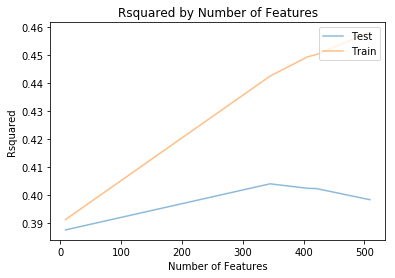

{'10000': 0.38769046344485592, '800': 0.40415371876609008, '550': 0.40253791252319171, '500': 0.40245968191525883, '300': 0.39848307665655536}
800


In [6]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [10000,800,550,500,300]
# cutoffs = [800,550]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [7]:
print(X_train.shape[1]) #Number of columns
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2


345
0.404153718766
0.442619284561


**6.** The larger the coefficient, the larger the expected impact on CareerSatisfaction. 

In [8]:
def coef_weights(coefficients, X_train):
  
    coefs_df = pd.DataFrame()
    coefs_df['est_var'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_var,coefs,abs_coefs
5,Professional_Professional developer,0.585434,0.585434
0,JobSatisfaction,0.518988,0.518988
219,DifficultCommunication_Strongly disagree,0.358335,0.358335
242,EquipmentSatisfiedRW_Very satisfied,-0.344064,0.344064
17,"EmploymentStatus_Independent contractor, freel...",0.340417,0.340417
239,EquipmentSatisfiedRW_Not very satisfied,-0.321037,0.321037
241,EquipmentSatisfiedRW_Somewhat satisfied,-0.298467,0.298467
35,CompanyType_Publicly-traded corporation,0.296132,0.296132
6,Professional_Professional non-developer who so...,0.278571,0.278571
11,Country_India,-0.267198,0.267198


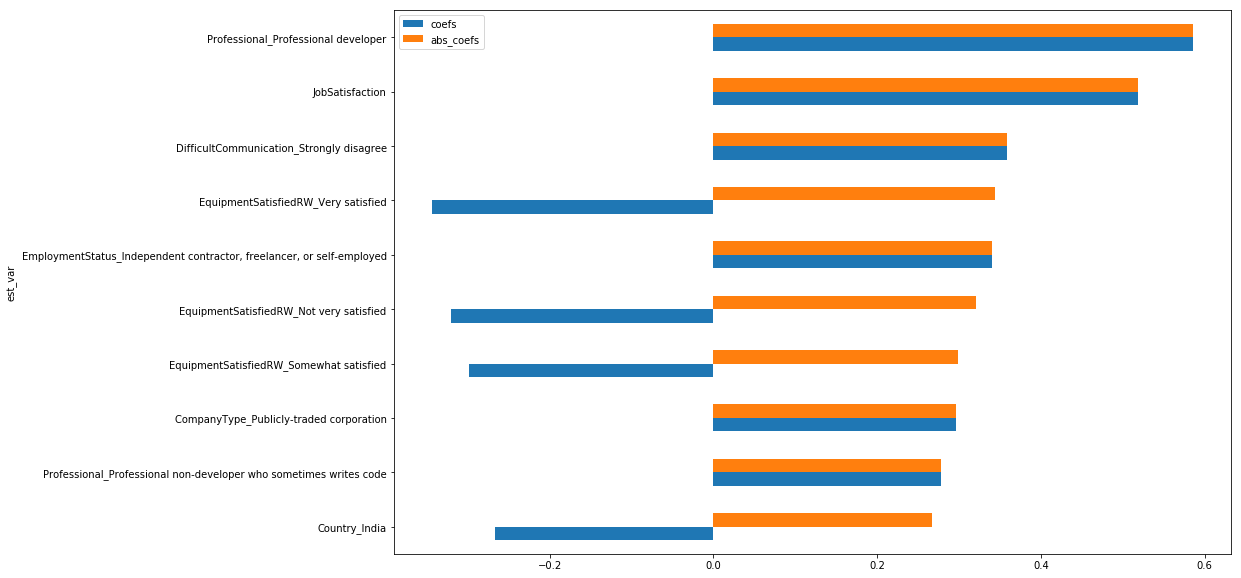

In [9]:
coef_df.set_index('est_var',inplace=True)
coef_df = coef_df.head(10).sort_values('abs_coefs', ascending=True)
# plt.figure(figsize=(10,5))#
(coef_df).plot(kind="barh",figsize=(15,10),sort_columns=True);


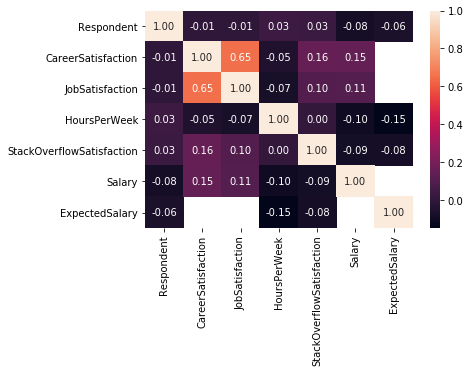

In [10]:
sns.heatmap(df.corr(), annot=True, fmt=".2f");

**Conclusion**
**1.**Master's degree and Bachelor's degree are the mainstream of professional developer in Germany which means higher education is important to become a professional developer.
**2.**We then looked at how different in terms of salary between male and female. This showed that male earn more in higher education and there is not too much correlation between higher education and salary for female.
**3.**Finally, we found that the people who had job with good communication and professional skill are usually satisfied with their careers .